
# CNNs through PyTorch

> Statistical Methods in AI, Monsoon '18




## Contents


### PyTorch

1. PyTorch Basics
2. Dataset
3. DataLoader
4. Model
5. Objectives, Optimizers and the Training Loop

### CNNs: Theory

1. Convolutional Filters
2. Pooling Layers
3. Activation Functions


 ![XKCD: Machine Learning](static/xkcd-machine_learning.png)


###  `np.ndarray`?
###  `tf.Tensor`?
## `torch.Tensor`!




In [1]:
import torch
from torch import nn, optim
from matplotlib import pyplot
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

pyplot.rc('font', size=SMALL_SIZE)          # controls default text sizes
pyplot.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
pyplot.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
pyplot.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
A = torch.Tensor([1, 2, 3])
A

tensor([1., 2., 3.])

In [3]:
B = A + 3 # Supports broadcast operations, like numpy.
B

tensor([4., 5., 6.])

## Why `torch.Tensor`?

* `autograd` enabled. No longer necessary to compute gradient update rules manually.
* CUDA backend - operations are many orders faster than numpy, which is not as fast.

## 8.2

Create a 2D synthetic data (Normal distribution) of 1000 samples  (i.e.,
$(x^1,x^2)$ from two classes with 50% in each of these classes.

You may chose your favorite mean and covariance. But make sure that a
linear classifier will have error (say the best possible error is in the
range 50-250 samples. (your data and parameter will differ from your
friends data!!).

...

## `torch.utils.data.Dataset`

We'll implement the 2D data in question as a `Dataset`. 

A dataset is something which requires a finite length, and indexed access gets a `(sample, target)` pair.

In [4]:
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.utils.data

class FakeDataset(torch.utils.data.Dataset):
    def __init__(self, mean, covariance, class_id, samples):
        self.distribution = MultivariateNormal(mean, covariance)
        self.class_id = class_id
        self.samples = samples
        self.mean = mean
        self.covariance = covariance
        
        self.data = self.generate_samples()
    
    def generate_samples(self):
        data = []
        for i in range(self.samples):
            sample = self.distribution.sample()
            data.append(sample)
        return data
    
    def __len__(self):
        return self.samples
    
     
    def __getitem__(self, idx):
        return (self.data[idx], self.class_id)

In [5]:
samples = 500

mean, covariance = torch.tensor([1, 1]).float(), torch.eye(2, 2).float()
first = FakeDataset(mean, covariance, class_id=0, samples=samples)

mean, covariance = torch.tensor([3, 3]).float(), torch.eye(2, 2).float()
second = FakeDataset(mean, covariance, class_id=1, samples=samples)

\begin{align*}
\mu_0 &= \begin{bmatrix} 1 \\ 1\end{bmatrix} & \Sigma_0 &= \begin{bmatrix}1 & 0 \\0 &1 \end{bmatrix} & \text{# class 0} \\
\mu_1 &= \begin{bmatrix} 3 \\ 3\end{bmatrix} & \Sigma_1 &= \begin{bmatrix}1 & 0 \\0 &1 \end{bmatrix} & \text{# class 1}
\end{align*}

### Question

What's the Bayes Optimal Decision Boundary for the above?

## `torch.utils.data.DataLoader`

A `DataLoader` is an abstraction which enables fast and parallel loading of data (images, videos etc) and provides options for batching, shuffling and splitting the `Dataset`. 

`Transforms` additionally help in preprocessing data (feature extraction) which are also built into the dataloader. 

In [6]:
dataset = torch.utils.data.ConcatDataset([first, second])
loader = torch.utils.data.DataLoader(dataset, shuffle=True)

In [7]:
def visualize_datapoints(first, second, boundaries=[]):
    def datapoints(dset):
        loader = torch.utils.data.DataLoader(dset, batch_size=len(dset))
        pts, labels = next(iter(loader))
        xys = pts.numpy()
        xs, ys = xys[:, 0], xys[:, 1]
        return (xs, ys)
        
    xs, ys = datapoints(first)
    pyplot.figure(figsize=(20, 10))
    pyplot.scatter(xs, ys, label='class 0')
    
    xs, ys = datapoints(second)
    pyplot.scatter(xs, ys, label='class 1')
    
    def draw(boundary):
        w, title  = boundary
        eps = 1e-9
        f = lambda x: -(w[0] + w[1]*x)/(w[2] + eps)
        xs = torch.linspace(start=-1, end=+5, steps=100)
        ys = f(xs)
        pyplot.plot(xs.numpy(), ys.numpy(), label=title)
    for boundary in boundaries:
        draw(boundary)
    
    pyplot.legend()
    return pyplot

In [9]:
_ = visualize_datapoints(first, second)

## 8.3 

Learn a logistic regression classifier with gradient descent. Find the
error on this data. (write your own code that implements gradient
descent. also submit the code). Repeat this with bias and without bias.
Do you find any difference?

Plot the decision boundaries (Bayesian optimal, LR with bias, LR without
bias) on a 2D plane and Submit. (show samples from different classes
with different colour.)

...

In [10]:
class MultinomialLogisticRegressor(nn.Module):
    def __init__(self, input_feature_dim,  output_classes, bias=True):
        super().__init__()
        self.input_feature_dim = input_feature_dim
        self.output_classes = output_classes        
        self.W = nn.Linear(input_feature_dim, output_classes, bias=bias)
        
    def forward(self, input_feature):
        o = input_feature
        o = self.W(o)
        return o

In [11]:
def run_epoch(loader, model, criterion, opt, device):
    total_loss, total_count = 0, 0
    
    model = model.to(device)
    for sample, target in loader:
        
        sample = sample.to(device)
        target = target.to(device)
        
        opt.zero_grad()   
        
        prediction = model(sample)
        loss = criterion(prediction, target)
        loss.backward()
        
        opt.step()
        
        total_loss += loss.item()
        total_count += 1
        
    return total_loss/total_count

## Gradient Updates: Explained

Before any computation, we clear out the existing gradients through `opt.zero_grad()`.

```python
for sample, target in loader:
    opt.zero_grad()   
```

The forward pass happens below.

```python
    prediction = model(sample)
```


Gradients for each parameter `x` are stored as an attribute, `x.grad`.

```python
    loss = criterion(prediction, target)
    loss.backward()
```

Now, all the optimizer has to do is visit each parameter and `x = x - eta * x.grad`. Which is achieved through the following function.


```python
    opt.step()
```

## Resources

Basic implementations which helps see how autograd is implemented can be found in the below notebook.

[CS 6501-004: Vision & Language Vicente Ordonez, Deep Learning Lab](http://www.cs.virginia.edu/~vicente/vislang/notebooks/deep_learning_lab.html)

In [12]:
model = MultinomialLogisticRegressor(input_feature_dim=2, output_classes=2)
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(),  lr=1e-2, momentum=0.8)
max_epochs = 100


def train(max_epochs, loader, model, criterion, opt, device):
    losses = []
    for epoch in range(max_epochs):
        loss = run_epoch(loader, model, criterion, opt, device)
        losses.append(loss)
    return losses

device = torch.device("cuda")
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=25)
losses = train(max_epochs, loader, model, criterion, opt, device)

In [13]:
def loss_plot(losses):
    max_epochs = len(losses)
    times = list(range(1, max_epochs+1))
    pyplot.figure(figsize=(30, 7))
    pyplot.xlabel("epochs")
    pyplot.ylabel("cross-entropy loss")
    return pyplot.plot(times, losses)

In [14]:
_ = loss_plot(losses)

We know that the probability for the two classes are given by the below functions.

\begin{align*}
f(0, x) &= {\bf \theta}_0^T{\bf x} & g(0, {\bf x}) &= (1 + \exp( f(0, {\bf x}) )^{-1} \\
f(1, x) &= {\bf \theta}_1^T{\bf x} & g(1, {\bf x}) &= (1 + \exp( f(1, {\bf x}) )^{-1} \\
\end{align*}

Decision boundary is given by $g(0, x) = g(1, x)$, which leads to $f(0, x) = f(1, x)$.

i.e, 
\begin{align*}
f(0, x) - f(1, x) &= 0 \implies & ({\bf \theta}_0 - {\bf \theta}_1)^T{\bf x} &= 0 
\end{align*}

In [14]:
boundaries = model.W.parameters()
W, b = list(boundaries)
_W = W.new(2, 3)
_W[:,1:] = W.data
_W[:, 0] = b.data
w = _W[0, :] - _W[1, :]
w = w.cpu().numpy()

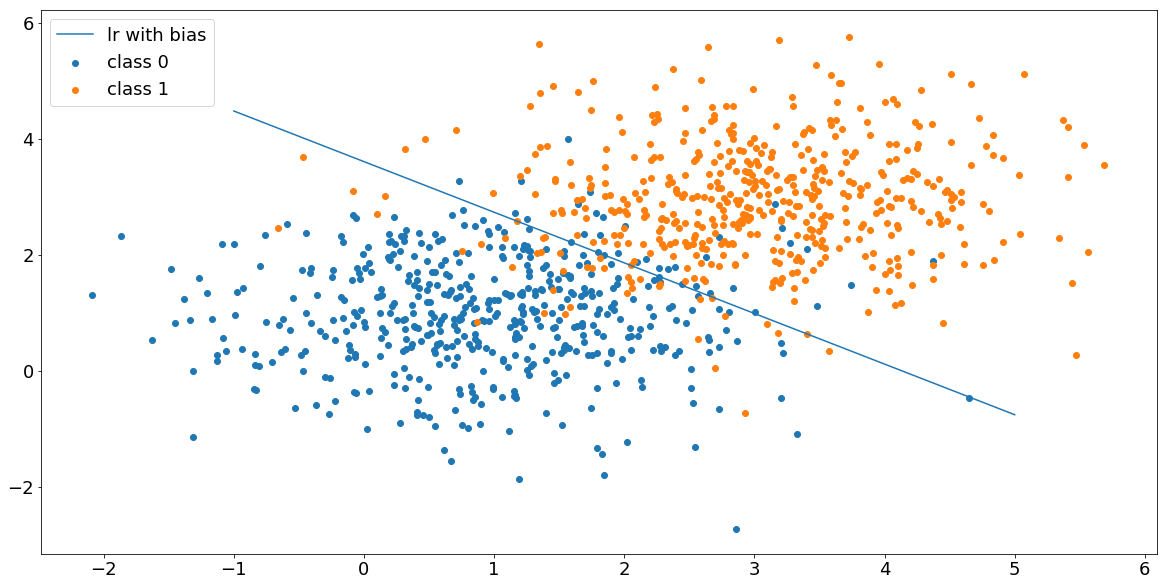

In [15]:
_ = visualize_datapoints(first, second, boundaries=[(w, 'lr with bias')])

## Question

1. How would you realize `LinearRegression` with MSELoss with the PyTorch framework, similar to `MultinomialLogisticRegression` above?
2. What modifications are required above to convert the above into logistic regression without bias, as in the question. Would the perfomance improve or degrade? Justify.

## MNIST Dataset

In [16]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

preprocess = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
mnist_trainset = datasets.MNIST(root='./data/mnist',  
                                train=True, 
                                download=True,   
                                transform=preprocess)

In [17]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1)

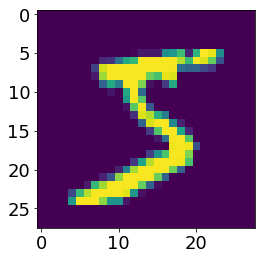

In [18]:
sample, target = next(iter(mnist_train_loader))

from matplotlib import pyplot
def visualize(sample, target):
    formatted = (sample.view(28, 28)
                 .contiguous()
                 .numpy())
    pyplot.imshow(formatted)
    
visualize(sample, target)

## MultiLayerPerceptron


#### The 3 Layer Case

![3 Layer Perceptron](static/mlp.png)

In [19]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_classes):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_classes = output_classes
        
        self.W_hx = nn.Linear(self.input_size, self.hidden_size)
        self.W_yh = nn.Linear(self.hidden_size, self.output_classes)
    
    def forward(self, sample):
        o = sample
        o = self.W_hx(o)
        o = torch.sigmoid(o)
        o = self.W_yh(o)
        return o
        

In [20]:
input_size = 28*28
hidden_size = 1000
output_classes = 10

vnn = SimpleMLP(input_size, 
               hidden_size, 
               output_classes)
vopt = optim.Adam(vnn.parameters(), lr=1e-2)
vcriterion = nn.CrossEntropyLoss()

In [31]:
preprocess = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(lambda x: x.view(-1).contiguous())
                       ])


mnist_trainset = datasets.MNIST(root='./data/mnist', 
                                train=True, 
                                download=True, 
                                transform=preprocess)

In [22]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64)
device = torch.device("cuda")
losses = train(max_epochs, mnist_train_loader, vnn, vcriterion, vopt, device)

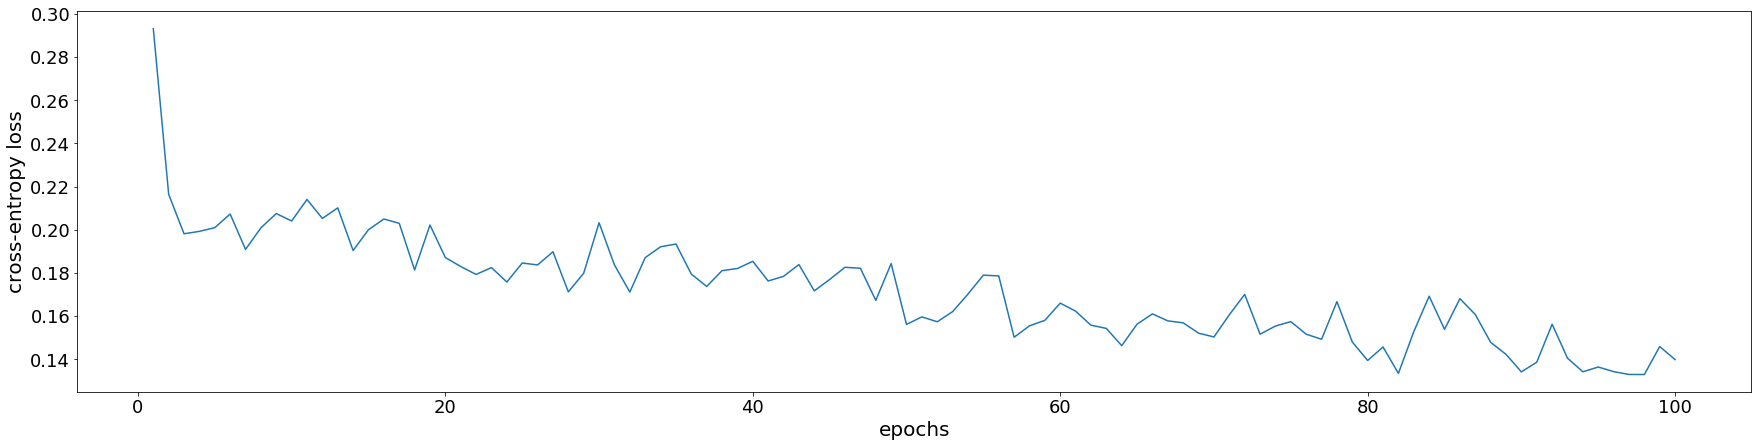

In [23]:
_ = loss_plot(losses)

## MultiLayerPerceptron

# Convolutional Neural Networks

#### CNNs Motivation
1. Regular neural networks do not scale to images
2. Full connectivity leads to large number of parameters that might lead to overfitting
3. CNNs contain neurons in 3 dimensions which better leverages input of images
4. Outputs 3D volume of activations and finally reduced to vector of class scores for a classification problem

### Fully Connected layer

![CNN:FCN](static/0.png)

FCN 

* operates over vectors
* if hidden layer has 10 neurons then each neuro will be the result of taking
    dot product with 32*32*3 weight parameters.So if 10 such neurons number of parameters will 
    10*3072
    

### CNN operates over volume.

![CNN:Image](static/1.png)

* We preserve the spatial structure.

![CNN:2](static/2.png)

![CNN:3](static/3.png)

## Convolution operation 

![CNN:conv](static/CNN.gif)

![CNN:4](static/4.png)

* Conv net is a sereis of such convolutional layers stacked one on top of other.
* Impractical to have fully connected layers. So each neuron connected to local region of input.
* Helps capture spatial associations between features
* Filters always extend full depth of input volume (i.e. input XxYxZ, filter has to be MxNxZ)
* Each filter gives an activation map obtained by the "convolving" the filter on input. So more filters means greater depth of activation map. 

## Dimension of activation maps  

### Dimension of output given by (N - F) / Stride + 1


### However, in subsequent conv layers the volume shrinks quickly...

### So, what do we do ??

### pad the image with zeros around the edges.

* This preserves the saptial dimsion of the activation maps

### Dimension of output is then given by (N - F +2P) / Stride + 1

## Question 1

Suppose you have a 32 X 32 X 3 image and there are 10 filters of size 7 X 7 X 3, what will
be the size of output activation maps if the stride is 1?

* (N - F) / Stride + 1
 
 N = 32, F = 7, stride = 1
 
 => (32 - 7)/1 + 1 = 26 ; output activation map size = 26 X 26 X 10

## Question 2

What will be the number of parameters in a conv layer with filters of size 5 X 5 X 3 and there are 10 of them ? 

5*5*3*10 +10 = 760

### So what is actually happening ?


### Filters at layer 1
    1. How straight is a line at this given patch.
    2. is the given line an edge
    



#### Filters at level 2
    1. is the point in the patch a corner point
    2. What is the roundness of the image in the given patch and so on.


* In the subsequent layers we start asking more complicated questions.


* The main take away point is that we are extracting information from shallow layers and 
    and as we go deeper we sought to answer more abstract and complicated questions for example whether the given image    contain's a cat or a dog.

### The crucial step is to learn what questions to ask at each layer. 



* In the begining the all the filters are initialized randomly and ask the network to predict whether the given picture contains cat or dog. 

* The network makes some assumptions and based on the assumption, weights of the networks are learned, via back prop.




![CNN:5](static/5.png)

2. Pooling Layer

![CNN:pooling](static/pooling.png)


- To make representation smaller and more managable
- Performed over each activation map independently
- Max pooling slides window over map and chooses highest value for the entire window

- Dimensions?

3. Dropout
    
    ![Dropout](static/dropout.png)



- Randomly "drops" some weights
- Forces network to have redundant representation
- Considered an important tool against overfitting

4. Activation Functions
    - To bring in non-linearity (If linear, one hidden layer can give same output as n hidden layers)
    - Same activation functions as used in fully connected networks used with CNNs
    - Examples: Sigmoid, TanH, ReLU, Leaky ReLU, PReLU

### AlexNet

1. Designed by Alex Krizhevsky and published with Ilya Sutskever and Geoff Hinton.
2. Over 25000 citations
3. Winner of ImageNet challenge 2012
4. First deep convolutional neural network based architecture
5. Error rate ~11% lower than runner up team.
6. Led to widespread use of CNNs in Computer Vision


![AlexNet](static/alexnet.png)


### Solving MNIST with CNNs

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.749
[1,  4000] loss: 0.168
[1,  6000] loss: 0.122
[1,  8000] loss: 0.102
[1, 10000] loss: 0.083
[1, 12000] loss: 0.085
[1, 14000] loss: 0.075
[2,  2000] loss: 0.061
[2,  4000] loss: 0.055
[2,  6000] loss: 0.058
[2,  8000] loss: 0.049
[2, 10000] loss: 0.053
[2, 12000] loss: 0.053
[2, 14000] loss: 0.050
Finished Training


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 98 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
